In [1]:
import os
import subprocess
import glob
import pandas as pd
import io
import matplotlib.pyplot as plt
import json
import re
from datetime import datetime

import docx
from docx import Document

In [2]:
CREATE_SVG = True
CREATE_DOCX = True

#outputDir = '/home/jbecker/windows/20250302_hagen'
outputDir = './output'

if CREATE_DOCX:
    outputDocx = Document()
    section = outputDocx.sections[0]
    # Landscape A3
    section.page_width = docx.shared.Inches(16.54)
    section.page_height = docx.shared.Inches(11.69)
    style = outputDocx.styles['Normal']
    style.font.size = docx.shared.Pt(8)
    
    def createOutputDocxFilename():
        now = datetime.now()
        timestamp = now.strftime('%Y%m%d-%H%M%S') + f"{now.microsecond // 1000:03d}"
        return timestamp + '.docx'
    outputDocxFilename = os.path.join(outputDir, createOutputDocxFilename())


if CREATE_DOCX or CREATE_SVG:
    os.makedirs(outputDir, exist_ok=True)

In [3]:
fileNames = glob.glob(os.path.join('..', 'measurements', '20250301-143903541', '*.json'))
dcts = []
for fileName in fileNames:
    with open(fileName, 'r') as file:
        dct = json.load(file)
        dct['name'] = os.path.basename(fileName)
        dcts.append(dct)
        
dfsWithAllInfos = []
for dct in dcts:        
    outputDf = pd.DataFrame(dct['output'])
    filename = dct['name']
    pattern = r'.*-([^-]+)-(\d+)-(\d+)-(\d+).json'
    match = re.match(pattern, filename)
    kernel, nClustersText, nPointsText, idx = match.groups()
    nClusters = int(nClustersText)
    nPoints = int(nPointsText)
    profiles = dct['profiles']
    dfsWithAllInfos.append({ 'name': filename, 'kernel': kernel, 'n_clusters': nClusters, 'n_points': nPoints, 'output': outputDf, 'profiles': profiles })

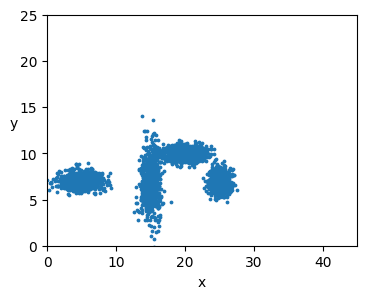

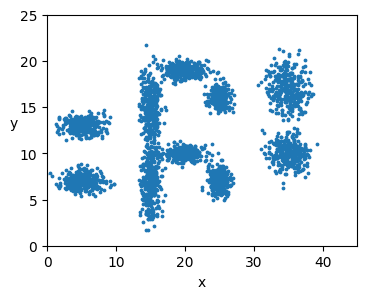

In [4]:
# Visualise datasets

def createDatasetScatters():
    def getFirstOutputDf(nClusters, nPoints):
        for dct in dfsWithAllInfos:
            if dct['n_clusters'] == nClusters and dct['n_points'] == nPoints:
                return dct['output']

    for nClusters, nPoints in [(4, 3162), (10, 3162)]:
        df = getFirstOutputDf(nClusters, nPoints)
        fig = plt.figure(figsize=(4,3))
        plt.scatter(df['x'], df['y'], s=3)
        plt.xlim(0,45)
        plt.ylim(0,25)
        plt.xlabel('x')
        plt.ylabel('y', rotation=0)
        plt.show()

        if CREATE_SVG:
            fig.savefig(os.path.join(outputDir, f'dataset_{nClusters:.0f}_{nPoints:.0f}.svg'), format='svg', bbox_inches='tight')

createDatasetScatters()

              x          y  is_core  cluster_id
0     24.736549  16.274981        1           1
1     23.854820   7.811450        1           2
2     19.857401  19.006420        1           3
3     20.880280  19.988411        1           4
4     26.493799   6.441350        1           5
...         ...        ...      ...         ...
3153   3.723830  13.251610        1         190
3154  16.132910   9.631540        0         147
3155  25.954411   5.923040        1           5
3156  34.322659  18.598101        1         146
3157  32.220348  16.747971        0           0

[3158 rows x 4 columns]
150


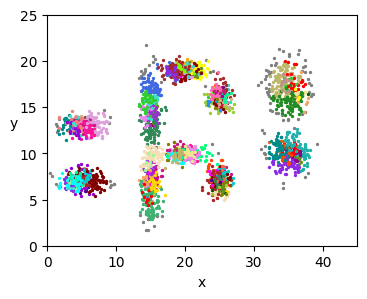

In [5]:
# Visualize b_boehm preclustering

def createBBoehmScatters(kernel):
    # Thank you, ChatGPT
    colors = [
        "#FF6347", "#FF4500", "#FF8C00", "#FFA500", "#FFD700", 
        "#FFFF00", "#9ACD32", "#32CD32", "#98FB98", "#00FF7F", 
        "#00FA9A", "#40E0D0", "#00FFFF", "#1E90FF", "#4169E1", 
        "#8A2BE2", "#9B30FF", "#FF00FF", "#C71585", "#DC143C", 
        "#FF1493", "#D2691E", "#8B4513", "#A52A2A", "#B22222", 
        "#FF0000", "#8B0000", "#800000", "#006400", "#228B22", 
        "#6B8E23", "#808000", "#DDA0DD", "#EE82EE", "#FF00FF", 
        "#FF69B4", "#C71585", "#F08080", "#FF7F50", "#FF6347", 
        "#F4A460", "#D2B48C", "#BC8F8F", "#F5DEB3", "#FF4500", 
        "#7CFC00", "#00FA9A", "#40E0D0", "#00CED1", "#48D1CC", 
        "#20B2AA", "#008B8B", "#3CB371", "#2E8B57", "#9ACD32", 
        "#6B8E23", "#808000", "#C71585", "#8A2BE2", "#4B0082", 
        "#9400D3", "#9932CC", "#8B008B", "#DDA0DD", "#EE82EE", 
        "#F0E68C", "#BDB76B", "#A52A2A", "#FF0000", "#B22222", 
        "#8B0000", "#800000", "#FFD700", "#FFFF00", "#9ACD32", 
        "#32CD32", "#98FB98", "#00FF7F", "#00FA9A", "#40E0D0", 
        "#00FFFF", "#1E90FF", "#4169E1", "#8A2BE2", "#9B30FF", 
        "#FF00FF", "#C71585", "#DC143C", "#FF1493", "#D2691E", 
        "#8B4513", "#A52A2A", "#B22222", "#FF0000", "#8B0000", 
        "#800000", "#006400", "#228B22", "#6B8E23", "#808000", 
        "#DDA0DD", "#EE82EE", "#FF00FF", "#FF69B4", "#C71585", 
        "#F08080", "#FF7F50", "#FF6347", "#F4A460", "#D2B48C", 
        "#BC8F8F", "#F5DEB3", "#FF4500", "#7CFC00", "#00FA9A", 
        "#40E0D0", "#00CED1", "#48D1CC", "#20B2AA", "#008B8B", 
        "#3CB371", "#2E8B57", "#9ACD32", "#6B8E23", "#808000", 
        "#C71585", "#8A2BE2", "#4B0082", "#9400D3", "#9932CC", 
        "#8B008B", "#DDA0DD", "#EE82EE", "#F0E68C", "#BDB76B", 
        "#A52A2A", "#FF0000", "#B22222", "#8B0000", "#800000", 
        "#FFD700", "#FFFF00", "#9ACD32", "#32CD32", "#98FB98", 
        "#00FF7F", "#00FA9A", "#40E0D0", "#00FFFF", "#1E90FF", 
        "#4169E1", "#8A2BE2", "#9B30FF", "#FF00FF", "#C71585", 
        "#DC143C", "#FF1493", "#D2691E", "#8B4513", "#A52A2A", 
        "#B22222", "#FF0000", "#8B0000", "#800000", "#006400", 
        "#228B22", "#6B8E23", "#808000", "#DDA0DD", "#EE82EE"
    ]    
    
    def getFirstOutputDf(kernel, nClusters, nPoints):
        for dct in dfsWithAllInfos:
            if dct['kernel'] == kernel and dct['n_clusters'] == nClusters and dct['n_points'] == nPoints:
                return dct['output']

    nClusters = 10
    nPoints = 3162
    df = getFirstOutputDf(kernel, nClusters, nPoints)
    print(df)
    fig = plt.figure(figsize=(4,3))
    idx = 0
    for cluster, grp in df.groupby('cluster_id'):
        if cluster == 0:
            plt.scatter(grp['x'], grp['y'], s=2, color='gray')
        else:
            plt.scatter(grp['x'], grp['y'], s=2, color=colors[idx % len(colors)])
            idx += 1
    print(len(set(df['cluster_id'])))
    plt.xlim(0,45)
    plt.ylim(0,25)
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.show()

    if CREATE_SVG:
        fig.savefig(os.path.join(outputDir, f'output_b_boehm_{nClusters:.0f}_{nPoints:.0f}.svg'), format='svg', bbox_inches='tight')

createBBoehmScatters('b_boehm')


              x          y  is_core  cluster_id
0     24.736549  16.274981        1           2
1     23.854820   7.811450        1           3
2     19.857401  19.006420        1           4
3     20.880280  19.988411        1           4
4     26.493799   6.441350        1           3
...         ...        ...      ...         ...
3153   3.723830  13.251610        1           6
3154  16.132910   9.631540        0           5
3155  25.954411   5.923040        1           3
3156  34.322659  18.598101        1          11
3157  32.220348  16.747971        0           0

[3158 rows x 4 columns]
11


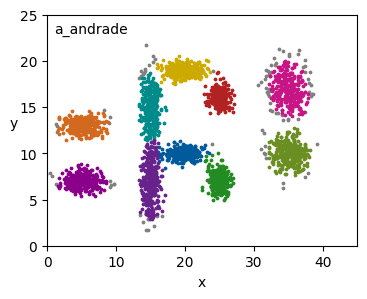

              x          y  is_core  cluster_id
0     24.736549  16.274981        1           1
1     23.854820   7.811450        1           2
2     19.857401  19.006420        1           3
3     20.880280  19.988411        1           3
4     26.493799   6.441350        1           2
...         ...        ...      ...         ...
3153   3.723830  13.251610        1          19
3154  16.132910   9.631540        0          21
3155  25.954411   5.923040        1           2
3156  34.322659  18.598101        1          41
3157  32.220348  16.747971        0           0

[3158 rows x 4 columns]
11


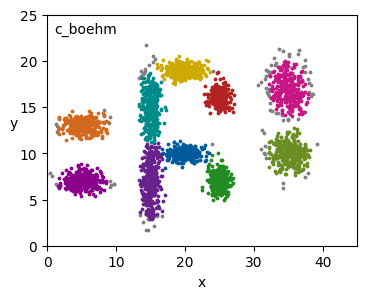

In [6]:
def createScatters(kernel):
    colors = [
        "#B22222",  # Dark Red
        "#228B22",  # Dark Green
        "#CDAA00",  # Dark Yellow (Goldenrod)
        "#005A9C",  # Dark Blue
        "#D2691E",  # Dark Orange (Chocolate)
        "#68228B",  # Dark Purple
        "#008B8B",  # Dark Cyan
        "#8B008B",  # Dark Magenta
        "#6B8E23",  # Dark Lime (Olive Drab)
        "#C71585"   # Dark Pink (Medium Violet Red)
    ]

    def getFirstOutputDf(kernel, nClusters, nPoints):
        for dct in dfsWithAllInfos:
            if dct['kernel'] == kernel and dct['n_clusters'] == nClusters and dct['n_points'] == nPoints:
                return dct['output']

    nClusters = 10
    nPoints = 3162
    df = getFirstOutputDf(kernel, nClusters, nPoints)
    print(df)
    fig = plt.figure(figsize=(4,3))
    idx = 0
    for cluster, grp in df.groupby('cluster_id'):
        if cluster == 0:
            plt.scatter(grp['x'], grp['y'], s=3, color='gray')
        else:
            plt.scatter(grp['x'], grp['y'], s=3, color=colors[idx])
            idx += 1
    print(len(set(df['cluster_id'])))
    plt.text(1,23, kernel)
    plt.xlim(0,45)
    plt.ylim(0,25)
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.show()

    if CREATE_SVG:
        fig.savefig(os.path.join(outputDir, f'output_{kernel}_{nClusters:.0f}_{nPoints:.0f}.svg'), format='svg', bbox_inches='tight')

createScatters('a_andrade')
createScatters('c_boehm')



In [7]:
# Create a single Pandas dataframe with the profiling data
def createDfAll():
    dfs = []
    for entry in dfsWithAllInfos:
        fileName = entry['name']
        kernel = entry['kernel']
        nClusters = entry['n_clusters']
        nPoints = entry['n_points']
        profilesDict = {}
        for k in entry['profiles'][0].keys():
            profilesDict[k] = []
        for rec in entry['profiles']:
            for k in profilesDict.keys():
                v = rec.get(k, None)
                profilesDict[k].append(v)
        nLines = len(entry['profiles'])
        profilesDict['fileName'] = [ fileName ] * nLines
        profilesDict['kernel' ] = [ kernel ] * nLines
        profilesDict['n_clusters' ] = [ nClusters ] * nLines
        profilesDict['n_points' ] = [ nPoints ] * nLines
        dfs.append(pd.DataFrame(profilesDict))
        
    dfAll = pd.concat(dfs)
    return dfAll
dfAll = createDfAll()

In [8]:
def aggregateTimes(df):
    # ChatGPT proposal
    quantiles = [0, 0.1, 0.5, 0.9, 1]  # min, 10%, median, 90%, max
    agg_funcs = {col: [min, 
                       lambda x: x.quantile(0.1), 
                       "median", 
                       lambda x: x.quantile(0.9), 
                       max] for col in df.columns if col.startswith('time') }

    other_columns = [col for col in df.columns if not col.startswith("time")]
    
    # Compute grouped statistics for 'time' columns
    result = df.groupby('fileName', as_index=False).agg({**agg_funcs, **{col: 'first' for col in other_columns}})
    
    # Flatten MultiIndex column names
    result.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) and col[1] else col for col in result.columns ]

    result = result.rename(columns=lambda x: x.replace("<lambda_0>", "q10")).rename(columns=lambda x: x.replace("<lambda_1>", "q90")).rename(columns=lambda x: x.replace("_first", ""))
    # Reset index to get 'key' back as a column
    #result.reset_index(inplace=True)
    return result

profileDfFinal = aggregateTimes(dfAll)

In [9]:
profileDfFinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timeNeighborCount_min          196 non-null    float64
 1   timeNeighborCount_q10          196 non-null    float64
 2   timeNeighborCount_median       196 non-null    float64
 3   timeNeighborCount_q90          196 non-null    float64
 4   timeNeighborCount_max          196 non-null    float64
 5   timePrefixScan_min             196 non-null    float64
 6   timePrefixScan_q10             196 non-null    float64
 7   timePrefixScan_median          196 non-null    float64
 8   timePrefixScan_q90             196 non-null    float64
 9   timePrefixScan_max             196 non-null    float64
 10  timeBuildIncidenceList_min     196 non-null    float64
 11  timeBuildIncidenceList_q10     196 non-null    float64
 12  timeBuildIncidenceList_median  196 non-null    flo

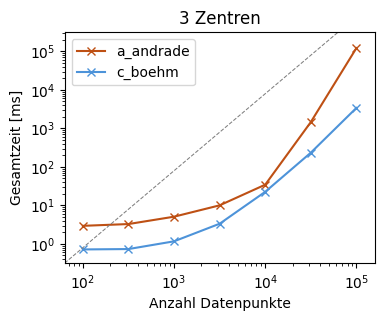

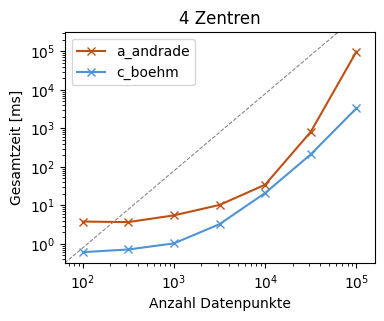

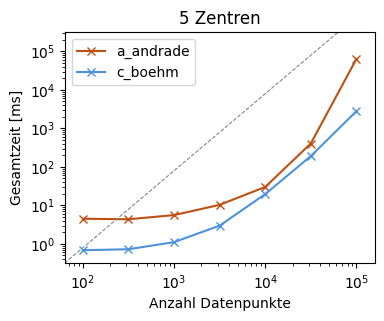

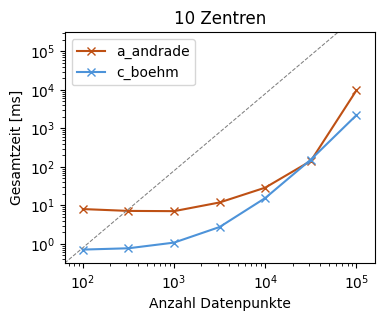

In [10]:
colors = {
    'a_andrade': '#BE5014', # brownish
    'c_boehm': '#4D93D9' # blue
}

profileDfBasicKernels = profileDfFinal[profileDfFinal['kernel'].isin(['a_andrade', 'c_boehm'])].copy()
profileDfBasicKernels.sort_values('n_points', inplace=True)
for nClusters, grp in profileDfBasicKernels.groupby('n_clusters'):
    fig = plt.figure(figsize=(4,3))
    for kernel, ggrp in grp.groupby('kernel'):
        ggrp = ggrp.sort_values('n_points')
        plt.plot(ggrp['n_points'], ggrp['timeTotal_median'], label=kernel, marker='x', color=colors[kernel])
    xlimits = [10**1.8, 10**5.2]
    ylimits = [10**-.5, 10**5.5]
    plt.plot(xlimits, [ylimits[0]/xlimits[0]**2 *x**2 for x in xlimits], color='gray', linestyle='--', linewidth='.75')
    plt.title(f'{nClusters} Zentren')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(xlimits[0], xlimits[1])
    plt.ylim(ylimits[0], ylimits[1])
    plt.xlabel('Anzahl Datenpunkte')
    plt.ylabel('Gesamtzeit [ms]')
    plt.legend()
    plt.show()

    if CREATE_SVG:
        fig.savefig(os.path.join(outputDir, f'total_a_c_{nClusters:.0f}.svg'), format='svg', bbox_inches='tight')

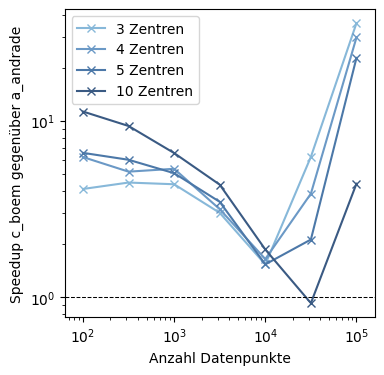

In [11]:
def createSpeedupDf():
    df1 = profileDfFinal[profileDfFinal['kernel']=='a_andrade']
    df2 = profileDfFinal[profileDfFinal['kernel']=='c_boehm']

    # ChatGPT ...
    # Set index to (nClusters, nPoints)
    df1.set_index(['n_clusters', 'n_points'], inplace=True)
    df2.set_index(['n_clusters', 'n_points'], inplace=True)
    
    # Compute the ratio
    result_df = (df1['timeTotal_median'] / df2['timeTotal_median']).reset_index()
    
    # Rename the column for clarity
    result_df.rename(columns={'timeTotal_median': 'speedup'}, inplace=True)

    return result_df
    
speedupDf = createSpeedupDf()

colors = ['#1f3a6d', '#3a5a83', '#4c78a8', '#6b99c6', '#87b8d9']



fig = plt.figure(figsize=(4,4))
idx = 0
for nClusters, ggrp in speedupDf.groupby('n_clusters'):
    ggrp = ggrp.sort_values('n_points')
    plt.plot(ggrp['n_points'], ggrp['speedup'], color=colors[4-idx], label=f'{nClusters:.0f} Zentren', marker='x')
    idx += 1

xlimits = [10**1.8, 10**5.2]
plt.plot(xlimits,[1]*2,linestyle='--', color='black', linewidth='.75')
#plt.title(f'{nClusters} Zentren')
plt.xscale('log')
plt.yscale('log')
plt.xlim(xlimits[0], xlimits[1])
#plt.ylim(1)
#plt.ylim(ylimits[0], ylimits[1])
plt.xlabel('Anzahl Datenpunkte')
plt.ylabel('Speedup c_boem gegenüber a_andrade')
plt.legend()
plt.show()

if CREATE_SVG:
    fig.savefig(os.path.join(outputDir, f'speedup_a_c.svg'), format='svg', bbox_inches='tight')

In [12]:
columnsToShow = ['kernel', 'n_points', 'n_clusters'] + [col for col in profileDfBasicKernels if col.endswith('_median')]
dfAndradeAllTimes = profileDfBasicKernels[profileDfBasicKernels['kernel']=='a_andrade'].sort_values(['n_clusters', 'n_points'])[columnsToShow]

In [13]:
dfAndradeAllTimes

,kernel,n_points,n_clusters,timeNeighborCount_median,timePrefixScan_median,timeBuildIncidenceList_median,timeMarkCoreUnvisited_median,timeFindComponents_median,timeTotal_median
7,a_andrade,100,3,0.036864,0.173088,0.050560,0.033920,1.53386,2.94083
11,a_andrade,316,3,0.049536,0.212576,0.048672,0.057664,1.81965,3.27235
8,a_andrade,1000,3,0.081216,0.246272,0.130784,0.057536,3.04128,5.08224
12,a_andrade,3162,3,0.322496,0.290432,1.056420,0.007072,5.65482,10.01980
9,a_andrade,10000,3,2.415620,0.400640,8.287230,0.008000,15.08110,34.45890
13,a_andrade,31623,3,23.177600,0.514048,123.179000,0.012448,1235.01000,1457.99000
10,a_andrade,100000,3,227.152000,0.501312,50163.800000,0.025600,67585.10000,121712.00000
14,a_andrade,100,4,0.034240,0.220224,0.036928,0.033952,2.00787,3.79453
18,a_andrade,316,4,0.041376,0.269632,0.046304,0.040064,2.12960,3.68064
15,a_andrade,1000,4,0.074912,0.244544,0.120352,0.035520,3.82672,5.51021


In [14]:
if CREATE_DOCX:
    def addToDocx(docxObj, df):
        dff = df.reset_index()
        nRows, nCols = dff.shape
        table = docxObj.add_table(rows=1, cols=nCols)
        hdrRow = table.rows[0].cells
        for i, columnName in enumerate(dff.columns):
            hdrRow[i].text = f'{columnName}'
        for _, row in dff.iterrows():
            rowCells = table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int,float)):
                    rowCells[i].text = f'{value:.3f}'
                    rowCells[i].paragraphs[0].alignment = docx.enum.text.WD_ALIGN_PARAGRAPH.RIGHT
                else:
                    rowCells[i].text = f'{value}'
    
    # outputDocx = docx.Document()
    outputDocx.add_paragraph()
    addToDocx(outputDocx, dfAndradeAllTimes)
    outputDocx.save(outputDocxFilename)

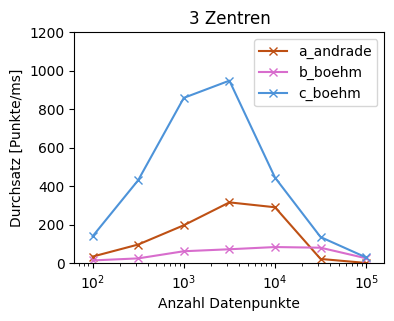

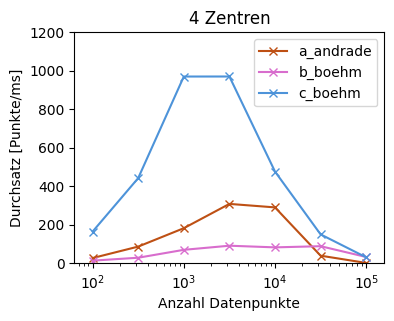

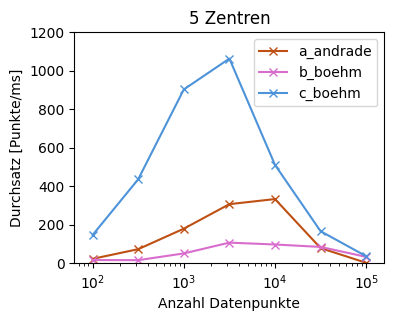

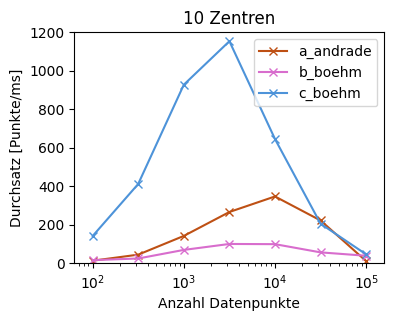

In [15]:
colors = {
    'a_andrade': '#BE5014', # brownish
    'b_boehm': '#D86DCD', # pink
    'c_boehm': '#4D93D9' # blue
}

profileDfBasicKernels = profileDfFinal[profileDfFinal['kernel'].isin(['a_andrade', 'b_boehm', 'c_boehm'])].copy()
profileDfBasicKernels.sort_values('n_points', inplace=True)
for nClusters, grp in profileDfBasicKernels.groupby('n_clusters'):
    fig = plt.figure(figsize=(4,3))
    for kernel, ggrp in grp.groupby('kernel'):
        ggrp = ggrp.sort_values('n_points')
        plt.plot(ggrp['n_points'], ggrp['n_points'] / ggrp['timeTotal_median'], label=kernel, marker='x', color=colors[kernel])
    xlimits = [10**1.8, 10**5.2]
    plt.title(f'{nClusters} Zentren')
    plt.xscale('log')
    plt.xlim(xlimits[0], xlimits[1])
    plt.ylim(0, 1200)
    plt.xlabel('Anzahl Datenpunkte')
    plt.ylabel('Durchsatz [Punkte/ms]')
    plt.legend()
    plt.show()

    if CREATE_SVG:
        fig.savefig(os.path.join(outputDir, f'throughput_a_b_c_{nClusters:.0f}.svg'), format='svg', bbox_inches='tight')

In [16]:
colors = {
    'a_andrade': '#BE5014', # brownish
    'c_boehm': '#4D93D9' # blue
}

andradeVersions = [ s for s in set(profileDfFinal['kernel']) if s.startswith('a_andrade') ]
andradeVersions.sort()
item = andradeVersions.pop(0)
andradeVersions.append(item)
andradeVersions

['a_andrade_01',
 'a_andrade_02',
 'a_andrade_04',
 'a_andrade_05',
 'a_andrade_texture',
 'a_andrade']

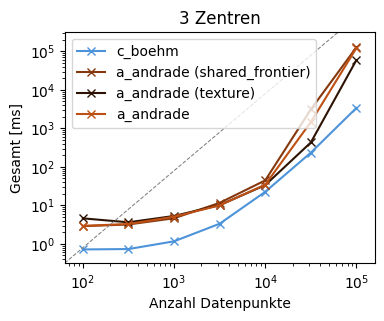

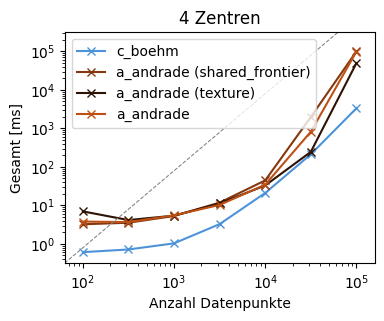

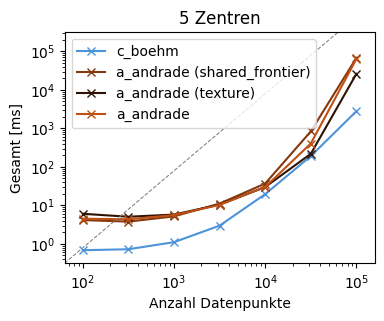

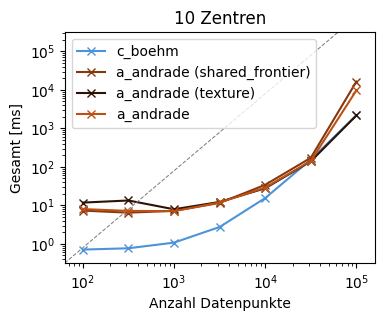

In [17]:
def createAndradeBfsPlots():
    andradeVersions = [
        'a_andrade_05',
        'a_andrade_texture',
        'a_andrade'
    ]
    labels = {
        'a_andrade_05': 'a_andrade (shared_frontier)',
        'a_andrade_texture': 'a_andrade (texture)',
        'a_andrade': 'a_andrade',
        'c_boehm': 'c_boehm'
    }
    def darkenHexColor(hex_color, factor=0.4):
        # delivered by ChatGPT :-)
        # Ensure the color starts with #
        if not hex_color.startswith("#"):
            hex_color = "#" + hex_color
    
        # Convert hex to RGB
        r = int(hex_color[1:3], 16)
        g = int(hex_color[3:5], 16)
        b = int(hex_color[5:7], 16)
    
        # Darken each component
        r = max(0, int(r * (1 - factor)))
        g = max(0, int(g * (1 - factor)))
        b = max(0, int(b * (1 - factor)))
    
        # Convert back to hex
        return f"#{r:02x}{g:02x}{b:02x}"

    colors = {
        'a_andrade': '#BE5014', # brownish
        'a_andrade_05': darkenHexColor('#BE5014', .3), # brownish
        'a_andrade_texture': darkenHexColor(darkenHexColor('#BE5014', .6)), # brownish
        'c_boehm': '#4D93D9' # blue
    }
    for nClusters, ggrp in profileDfFinal.groupby('n_clusters'):
        fig = plt.figure(figsize=(4,3))
        grp = ggrp[ggrp['kernel'] == 'c_boehm'].sort_values('n_points')
        plt.plot(grp['n_points'], grp['timeTotal_median'], marker='x', color=colors['c_boehm'], label=labels['c_boehm'])
        for kernel in andradeVersions:
            grp = ggrp[ggrp['kernel'] == kernel].sort_values('n_points')
            plt.plot(grp['n_points'], grp['timeTotal_median'], marker='x', color=colors[kernel], label=labels[kernel])
        xlimits = [10**1.8, 10**5.2]
        ylimits = [10**-.5, 10**5.5]
        plt.plot(xlimits, [ylimits[0]/xlimits[0]**2 *x**2 for x in xlimits], color='gray', linestyle='--', linewidth='.75')
        plt.title(f'{nClusters} Zentren')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(xlimits[0], xlimits[1])
        plt.ylim(ylimits[0], ylimits[1])
        plt.xlabel('Anzahl Datenpunkte')
        plt.ylabel('Gesamt [ms]')
        plt.legend()
        plt.show()
        
        if CREATE_SVG:
            fig.savefig(os.path.join(outputDir, f'bfs_a_{nClusters:.0f}.svg'), format='svg', bbox_inches='tight')

createAndradeBfsPlots()

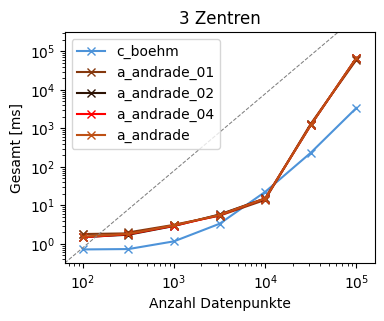

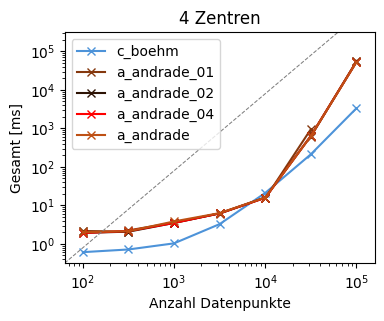

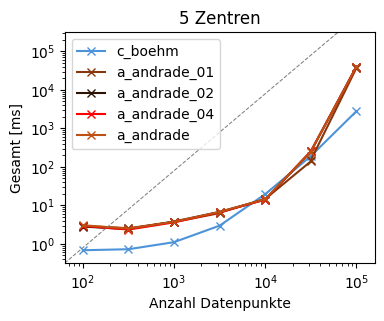

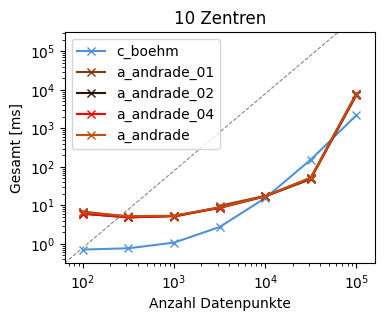

In [18]:
def createAndradeFindNextUnvisitedPlots():
    andradeVersions = [
        'a_andrade_01',
        'a_andrade_02',
        'a_andrade_04',
        'a_andrade'
    ]
    labels = {
        'a_andrade_01': 'a_andrade_01',
        'a_andrade_02': 'a_andrade_02',
        'a_andrade_04': 'a_andrade_04',
        'a_andrade': 'a_andrade',
        'c_boehm': 'c_boehm'
    }
    def darkenHexColor(hex_color, factor=0.4):
        # delivered by ChatGPT :-)
        # Ensure the color starts with #
        if not hex_color.startswith("#"):
            hex_color = "#" + hex_color
    
        # Convert hex to RGB
        r = int(hex_color[1:3], 16)
        g = int(hex_color[3:5], 16)
        b = int(hex_color[5:7], 16)
    
        # Darken each component
        r = max(0, int(r * (1 - factor)))
        g = max(0, int(g * (1 - factor)))
        b = max(0, int(b * (1 - factor)))
    
        # Convert back to hex
        return f"#{r:02x}{g:02x}{b:02x}"

    colors = {
        'a_andrade': '#BE5014', # brownish
        'a_andrade_01': darkenHexColor('#BE5014', .3), # brownish
        'a_andrade_02': darkenHexColor(darkenHexColor('#BE5014', .6)), # brownish
        'a_andrade_04': '#FF0000',
        'c_boehm': '#4D93D9' # blue
    }
    for nClusters, ggrp in profileDfFinal.groupby('n_clusters'):
        fig = plt.figure(figsize=(4,3))
        grp = ggrp[ggrp['kernel'] == 'c_boehm'].sort_values('n_points')
        plt.plot(grp['n_points'], grp['timeTotal_median'], marker='x', color=colors['c_boehm'], label=labels['c_boehm'])
        for kernel in andradeVersions:
            grp = ggrp[ggrp['kernel'] == kernel].sort_values('n_points')
            plt.plot(grp['n_points'], grp['timeFindComponents_median'], marker='x', color=colors[kernel], label=labels[kernel])
        xlimits = [10**1.8, 10**5.2]
        ylimits = [10**-.5, 10**5.5]
        plt.plot(xlimits, [ylimits[0]/xlimits[0]**2 *x**2 for x in xlimits], color='gray', linestyle='--', linewidth='.75')
        plt.title(f'{nClusters} Zentren')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(xlimits[0], xlimits[1])
        plt.ylim(ylimits[0], ylimits[1])
        plt.xlabel('Anzahl Datenpunkte')
        plt.ylabel('Gesamt [ms]')
        plt.legend()
        plt.show()
        
        if CREATE_SVG:
            fig.savefig(os.path.join(outputDir, f'bfs_a_{nClusters:.0f}.svg'), format='svg', bbox_inches='tight')

createAndradeFindNextUnvisitedPlots()

              x          y  is_core  cluster_id
0     24.736549  16.274981        1           4
1     23.854820   7.811450        1           2
2     19.857401  19.006420        1           3
3     20.880280  19.988411        1           3
4     26.493799   6.441350        1           2
...         ...        ...      ...         ...
3153   3.723830  13.251610        1           6
3154  16.132910   9.631540        0           5
3155  25.954411   5.923040        1           2
3156  34.322659  18.598101        1          11
3157  32.220348  16.747971        0           0

[3158 rows x 4 columns]
11


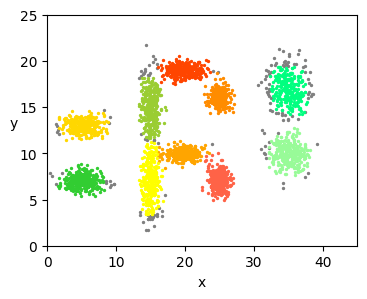

In [19]:
# Visualize a_andrade_texture clustering for 100000 points

def createAndradeTextureScatter():
    # Thank you, ChatGPT
    colors = [
        "#FF6347", "#FF4500", "#FF8C00", "#FFA500", "#FFD700", 
        "#FFFF00", "#9ACD32", "#32CD32", "#98FB98", "#00FF7F", 
        "#00FA9A", "#40E0D0", "#00FFFF", "#1E90FF", "#4169E1", 
        "#8A2BE2", "#9B30FF", "#FF00FF", "#C71585", "#DC143C", 
        "#FF1493", "#D2691E", "#8B4513", "#A52A2A", "#B22222", 
        "#FF0000", "#8B0000", "#800000", "#006400", "#228B22", 
        "#6B8E23", "#808000", "#DDA0DD", "#EE82EE", "#FF00FF", 
        "#FF69B4", "#C71585", "#F08080", "#FF7F50", "#FF6347", 
        "#F4A460", "#D2B48C", "#BC8F8F", "#F5DEB3", "#FF4500", 
        "#7CFC00", "#00FA9A", "#40E0D0", "#00CED1", "#48D1CC", 
        "#20B2AA", "#008B8B", "#3CB371", "#2E8B57", "#9ACD32", 
        "#6B8E23", "#808000", "#C71585", "#8A2BE2", "#4B0082", 
        "#9400D3", "#9932CC", "#8B008B", "#DDA0DD", "#EE82EE", 
        "#F0E68C", "#BDB76B", "#A52A2A", "#FF0000", "#B22222", 
        "#8B0000", "#800000", "#FFD700", "#FFFF00", "#9ACD32", 
        "#32CD32", "#98FB98", "#00FF7F", "#00FA9A", "#40E0D0", 
        "#00FFFF", "#1E90FF", "#4169E1", "#8A2BE2", "#9B30FF", 
        "#FF00FF", "#C71585", "#DC143C", "#FF1493", "#D2691E", 
        "#8B4513", "#A52A2A", "#B22222", "#FF0000", "#8B0000", 
        "#800000", "#006400", "#228B22", "#6B8E23", "#808000", 
        "#DDA0DD", "#EE82EE", "#FF00FF", "#FF69B4", "#C71585", 
        "#F08080", "#FF7F50", "#FF6347", "#F4A460", "#D2B48C", 
        "#BC8F8F", "#F5DEB3", "#FF4500", "#7CFC00", "#00FA9A", 
        "#40E0D0", "#00CED1", "#48D1CC", "#20B2AA", "#008B8B", 
        "#3CB371", "#2E8B57", "#9ACD32", "#6B8E23", "#808000", 
        "#C71585", "#8A2BE2", "#4B0082", "#9400D3", "#9932CC", 
        "#8B008B", "#DDA0DD", "#EE82EE", "#F0E68C", "#BDB76B", 
        "#A52A2A", "#FF0000", "#B22222", "#8B0000", "#800000", 
        "#FFD700", "#FFFF00", "#9ACD32", "#32CD32", "#98FB98", 
        "#00FF7F", "#00FA9A", "#40E0D0", "#00FFFF", "#1E90FF", 
        "#4169E1", "#8A2BE2", "#9B30FF", "#FF00FF", "#C71585", 
        "#DC143C", "#FF1493", "#D2691E", "#8B4513", "#A52A2A", 
        "#B22222", "#FF0000", "#8B0000", "#800000", "#006400", 
        "#228B22", "#6B8E23", "#808000", "#DDA0DD", "#EE82EE"
    ]    
    
    def getFirstOutputDf(kernel, nClusters, nPoints):
        for dct in dfsWithAllInfos:
            if dct['kernel'] == kernel and dct['n_clusters'] == nClusters and dct['n_points'] == nPoints:
                return dct['output']

    nClusters = 10
    nPoints = 3162
    df = getFirstOutputDf('a_andrade_texture', nClusters, nPoints)
    print(df)
    fig = plt.figure(figsize=(4,3))
    idx = 0
    for cluster, grp in df.groupby('cluster_id'):
        if cluster == 0:
            plt.scatter(grp['x'], grp['y'], s=2, color='gray')
        else:
            plt.scatter(grp['x'], grp['y'], s=2, color=colors[idx % len(colors)])
            idx += 1
    print(len(set(df['cluster_id'])))
    plt.xlim(0,45)
    plt.ylim(0,25)
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.show()

    if CREATE_SVG:
        fig.savefig(os.path.join(outputDir, f'output_b_boehm_{nClusters:.0f}_{nPoints:.0f}.svg'), format='svg', bbox_inches='tight')

createAndradeTextureScatter()


In [20]:
colors = {
    'a_andrade': '#BE5014', # brownish
    'b_boehm': '#D86DCD', # pink
    'c_boehm': '#4D93D9' # blue
}

boehmkernelvariants = [ s for s in set(profileDfFinal['kernel']) if s.startswith('b_boehm_') ]
profileDfBBoehmKernels = profileDfFinal[profileDfFinal['kernel'].isin(boehmkernelvariants)].copy()
profileDfBBoehmKernels.sort_values('n_points', inplace=True)

def extractMaxSeedSize(kernel):
    pattern = r'.*_(\d+)$'
    match = re.match(pattern, kernel)
    maxSeedSize, = match.groups()
    return int(maxSeedSize)

profileDfBBoehmKernels['maxSeedSize'] = [ extractMaxSeedSize(s) for s in profileDfBBoehmKernels['kernel'] ]

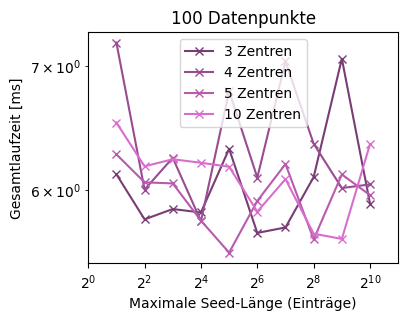

[1.0370588607773057, 1.046805722625308, 1.0742097369635442, 1.1253048002495107]


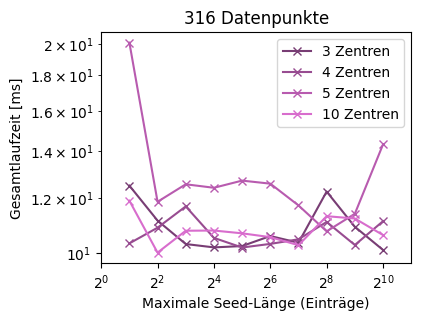

[1.0, 1.0910645490997721, 1.3338052965450429, 1.0599348273725033]


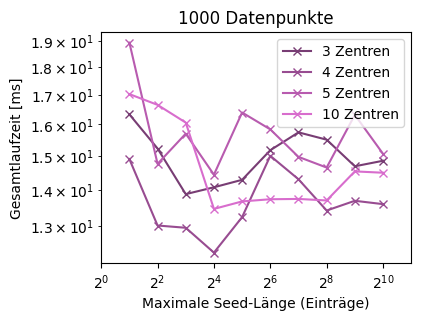

[1.0706584409594098, 1.1042964720026645, 1.0436736870537229, 1.0768716478226634]


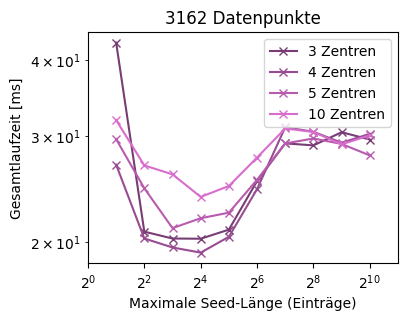

[1.4580555706327314, 1.5705256258193396, 1.31831861720531, 1.263628442626056]


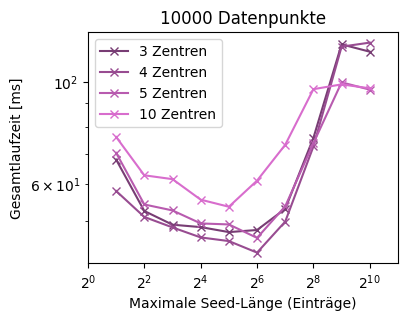

[2.4648883980986107, 2.858204424357643, 2.0986449734677834, 1.808196712145976]


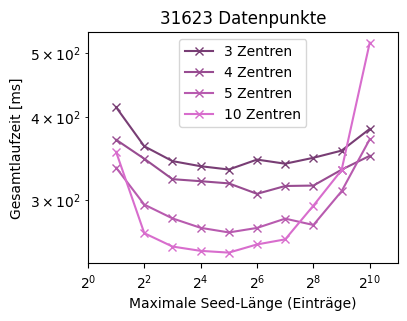

[1.1519336519606371, 1.1414931490310098, 1.3832452447072174, 2.077211388299363]


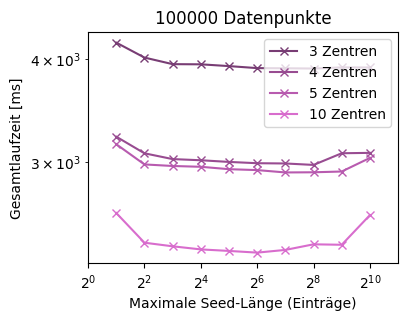

[1.0029407232381344, 1.034253735105793, 1.0413889213068162, 1.1104217829603806]


In [21]:
def makeBBoehmPlots():
    colors = {
        10: '#D86DCD',
        5: "#B85BAF",  # Darker Pinkish-Purple
        4: "#984C91",  # Even Darker Pinkish-Purple
        3: "#783D74"   # Deep Dark Pinkish-Purple
    }
    for nPoints, grp in profileDfBBoehmKernels.groupby('n_points'):
        factors = []
        fig = plt.figure(figsize=(4,3))
        for nClusters, ggrp in grp.groupby('n_clusters'):
            ggrp = ggrp.sort_values('maxSeedSize')
            plt.plot(ggrp['maxSeedSize'], ggrp['timeTotal_median'], label=f'{nClusters} Zentren', marker='x', color=colors[nClusters])
            factors.append(max(ggrp[ggrp['maxSeedSize']==1024]['timeTotal_median']) / min(ggrp['timeTotal_median']))
        plt.xlim(1, 2048)
    #    plt.ylim(0, 600)
    #    plt.ylim(0, 1200)
        plt.xlabel('Maximale Seed-Länge (Einträge)')
        plt.ylabel('Gesamtlaufzeit [ms]')
        plt.xscale('log', base=2)
        plt.yscale('log')
        plt.title(f'{nPoints} Datenpunkte')
        plt.legend()
        plt.show()
        print(factors)

        
        if CREATE_SVG:
            fig.savefig(os.path.join(outputDir, f'runtime_seed_b_boehm_{nPoints:.0f}.svg'), format='svg', bbox_inches='tight')

makeBBoehmPlots()